✓ Imports carregados
✓ Configurações definidas
✓ resultados_redes.json carregado

✓ 42 sites carregados
✓ 406 dark pools identificados

✓ Grafo construído:
  Sites: 25
  SSPs: 125
  Arestas: 539
  Densidade: 0.048


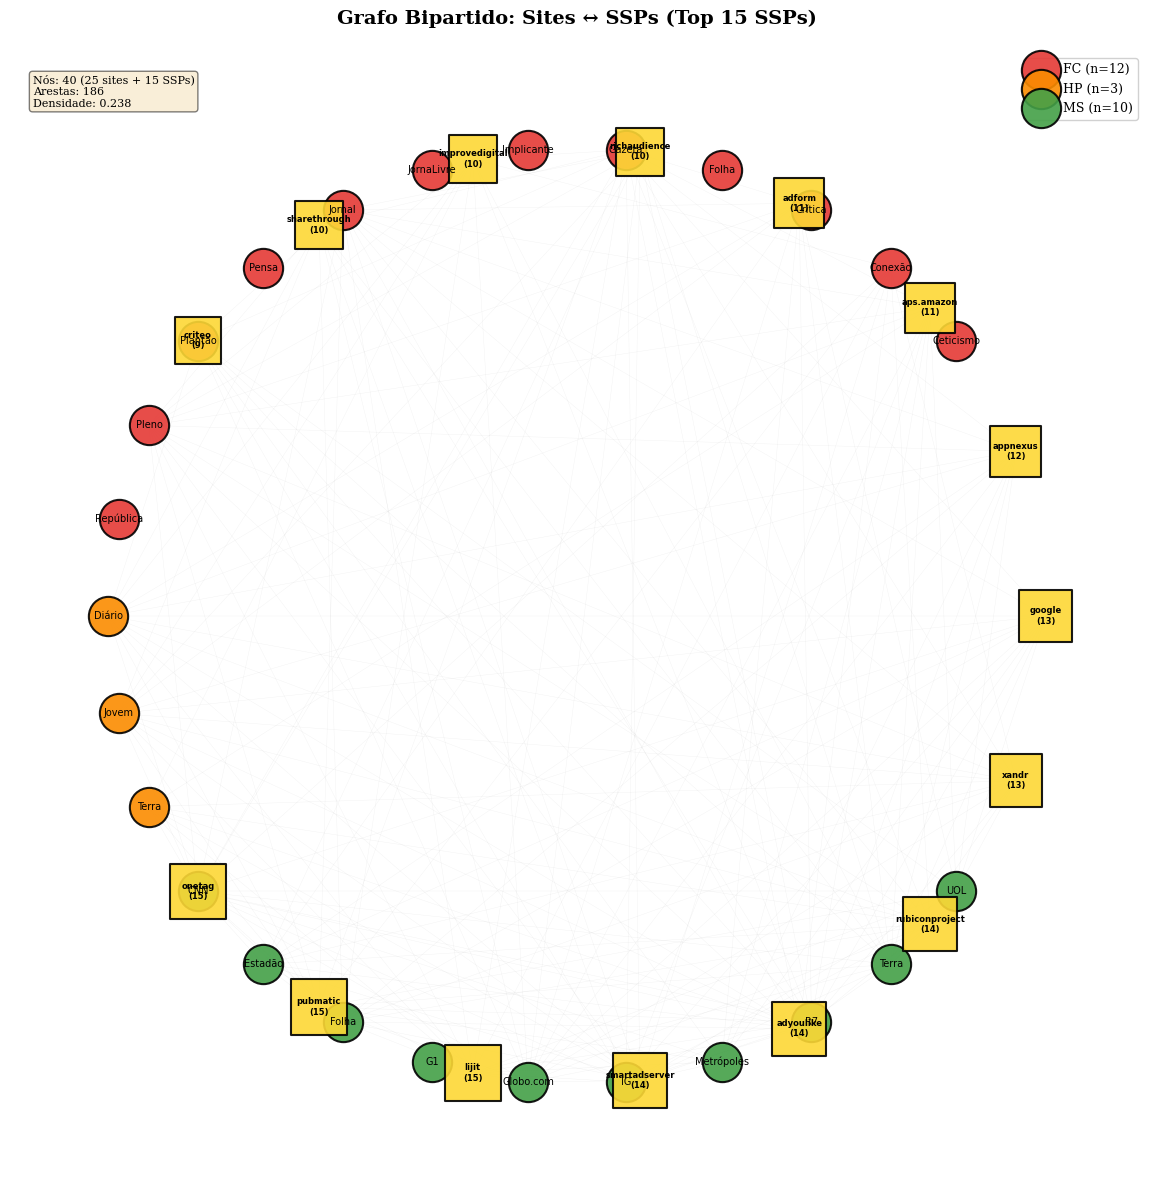

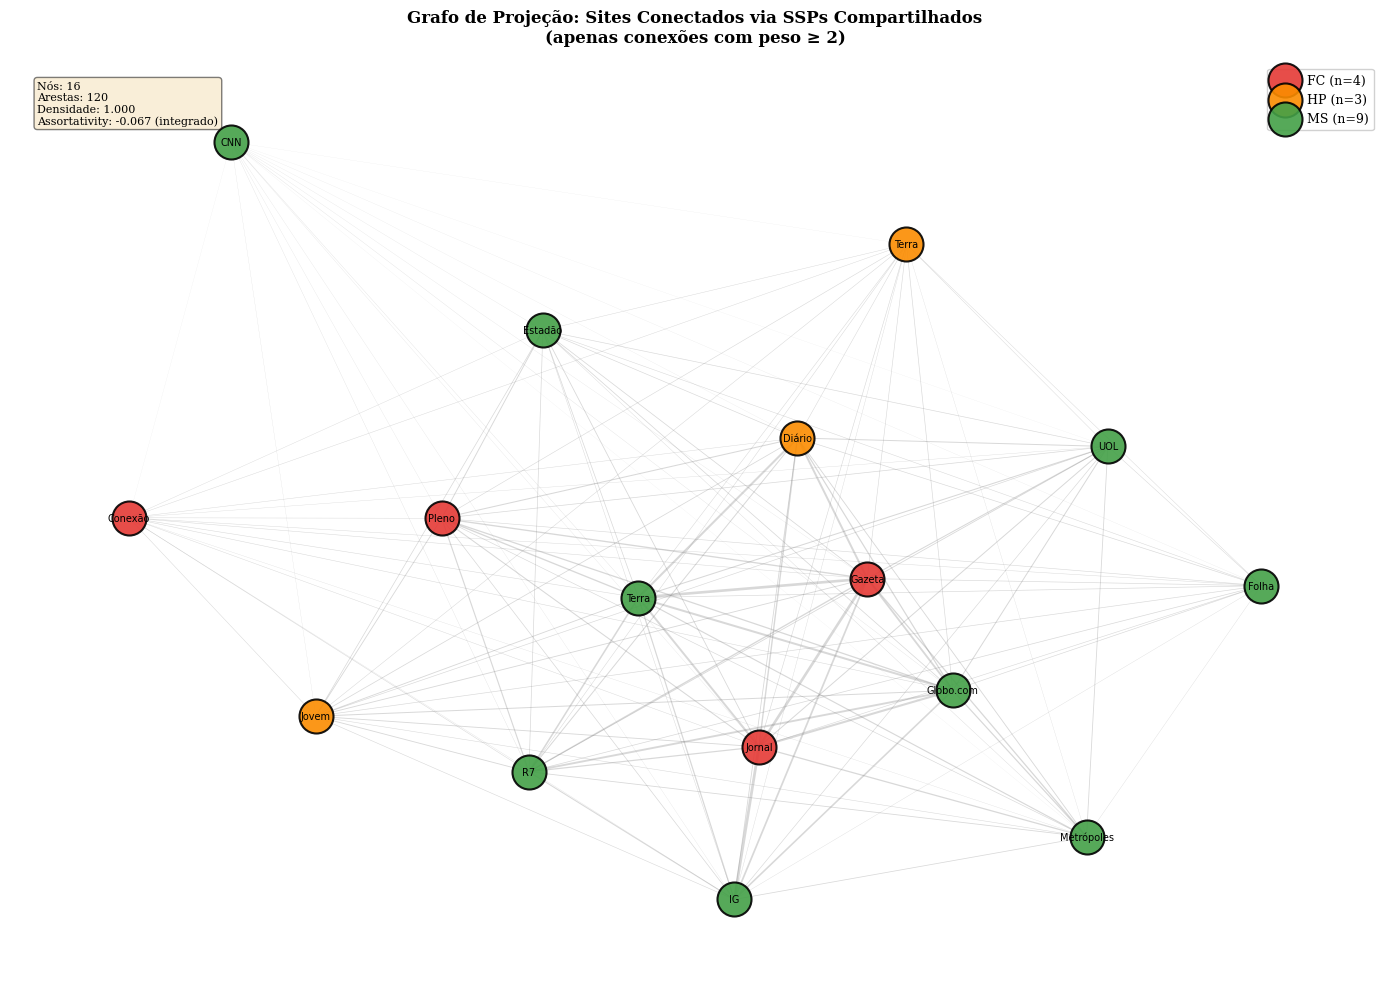

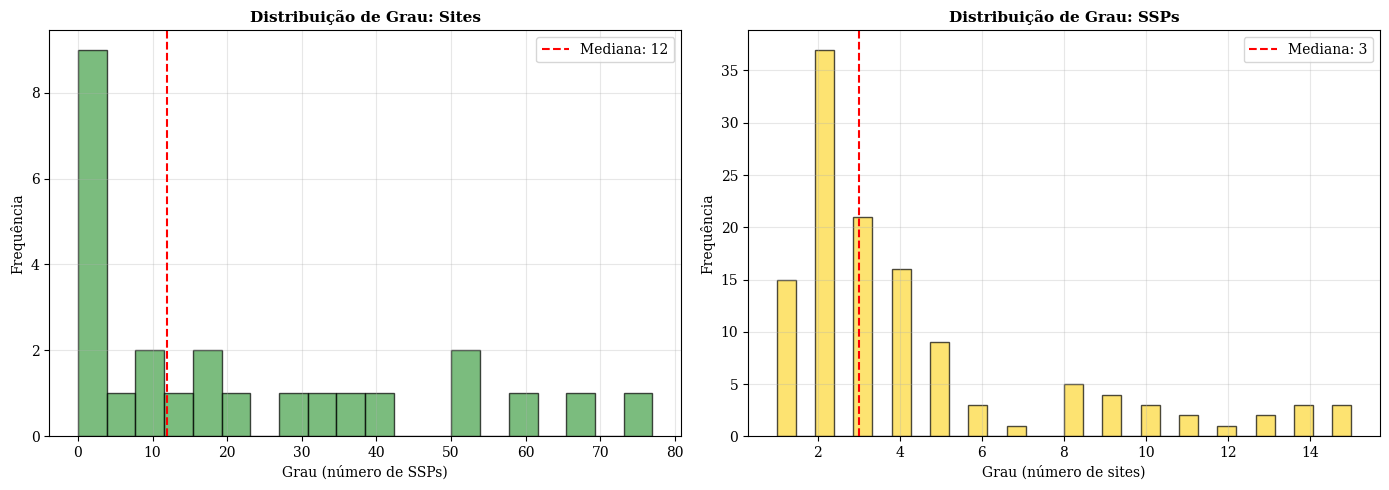

/tmp/ipykernel_1246484/3998245520.py:375: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(dados, labels=labels, patch_artist=True,


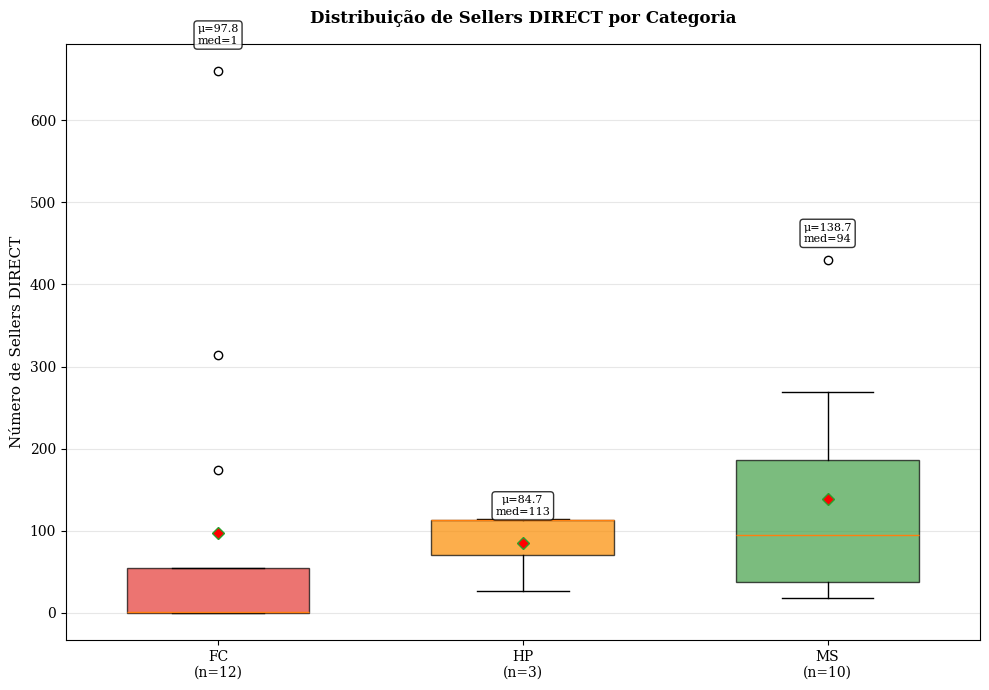

TOP 20 SSPs POR GRAU:
------------------------------------------------------------
 1. lijit.com                                → 15 sites
 2. onetag.com                               → 15 sites
 3. pubmatic.com                             → 15 sites
 4. rubiconproject.com                       → 14 sites
 5. adyoulike.com                            → 14 sites
 6. smartadserver.com                        → 14 sites
 7. google.com                               → 13 sites
 8. xandr.com                                → 13 sites
 9. appnexus.com                             → 12 sites
10. aps.amazon.com                           → 11 sites
11. adform.com                               → 11 sites
12. richaudience.com                         → 10 sites
13. sharethrough.com                         → 10 sites
14. improvedigital.com                       → 10 sites
15. criteo.com                               →  9 sites
16. amxrtb.com                               →  9 sites
17. themediagrid.com 

In [1]:
"""
GERAÇÃO DE GRAFOS - JUPYTER NOTEBOOK
Para uso interativo: rode célula por célula, ajuste e visualize

Cada célula gera um gráfico diferente
Use plt.show() para visualizar inline
"""

# ============================================================================
# CÉLULA 1: IMPORTS E CONFIGURAÇÃO
# ============================================================================

import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from collections import defaultdict

# Configuração matplotlib
%matplotlib inline
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100  # Para notebook, use 100. Para salvar, use 300

# Cores (CUSTOMIZE AQUI!)
CORES = {
    'FC': '#E53935',    # Vermelho escuro
    'HP': '#FB8C00',    # Laranja
    'MS': '#43A047',    # Verde escuro
    'SSP': '#FDD835',   # Amarelo
}

# Tamanhos (CUSTOMIZE AQUI!)
TAMANHOS = {
    'site': 800,
    'ssp_base': 400,
    'ssp_escala': 80,
}

print("✓ Imports carregados")
print("✓ Configurações definidas")


# ============================================================================
# CÉLULA 2: CARREGAR DADOS
# ============================================================================

# Carregar JSONs
with open('resultados_completos.json', 'r') as f:
    dados = json.load(f)

try:
    with open('resultados_redes.json', 'r') as f:
        redes = json.load(f)
    print("✓ resultados_redes.json carregado")
except:
    redes = None
    print("⚠ resultados_redes.json não encontrado (ok para grafos básicos)")

sites_data = dados['sites']
dark_pools_data = dados['dark_pools']

print(f"\n✓ {len(sites_data)} sites carregados")
print(f"✓ {dark_pools_data['total']} dark pools identificados")


# ============================================================================
# CÉLULA 3: CONSTRUIR GRAFO BIPARTIDO
# ============================================================================

def construir_grafo():
    """Constrói grafo bipartido Sites ↔ SSPs"""
    
    G = nx.Graph()
    
    # Adicionar sites
    for nome, data in sites_data.items():
        if data.get('sucesso'):
            G.add_node(nome, 
                      bipartite=1, 
                      tipo='site', 
                      categoria=data['cat'],
                      n_sellers=data.get('n_direct_raw', 0))
    
    # Adicionar SSPs e arestas
    pools = dark_pools_data['pools']
    
    for seller, pool_data in pools.items():
        ssp_domain = seller.split('#')[0]
        
        if ssp_domain not in G:
            G.add_node(ssp_domain, bipartite=0, tipo='ssp', grau=0)
        
        for site in pool_data['sites']:
            if site in G:
                if not G.has_edge(site, ssp_domain):
                    G.add_edge(site, ssp_domain, weight=1)
                else:
                    G[site][ssp_domain]['weight'] += 1
    
    # Calcular graus
    for node in G.nodes():
        if G.nodes[node].get('tipo') == 'ssp':
            G.nodes[node]['grau'] = G.degree(node)
    
    return G

# Construir grafo
G = construir_grafo()

# Estatísticas
sites = [n for n, d in G.nodes(data=True) if d.get('tipo') == 'site']
ssps = [n for n, d in G.nodes(data=True) if d.get('tipo') == 'ssp']

print(f"\n✓ Grafo construído:")
print(f"  Sites: {len(sites)}")
print(f"  SSPs: {len(ssps)}")
print(f"  Arestas: {len(G.edges())}")
print(f"  Densidade: {nx.density(G):.3f}")


# ============================================================================
# CÉLULA 4: FIGURA 1 - GRAFO BIPARTIDO
# ============================================================================

# PARÂMETROS AJUSTÁVEIS:
TOP_N_SSPS = 15        # Quantos SSPs mostrar
FIGSIZE = (18, 12)     # Tamanho da figura
LARGURA_ARESTA = 0.3   # Espessura das linhas
ALPHA_ARESTA = 0.1     # Transparência das linhas

# Filtrar top SSPs
ssps_graus = [(ssp, G.nodes[ssp]['grau']) for ssp in ssps]
top_ssps = set([ssp for ssp, _ in sorted(ssps_graus, key=lambda x: x[1], reverse=True)[:TOP_N_SSPS]])

nodes_manter = [n for n in G.nodes() if G.nodes[n].get('tipo') == 'site' or n in top_ssps]
G_sub = G.subgraph(nodes_manter).copy()

sites_sub = sorted([n for n, d in G_sub.nodes(data=True) if d.get('tipo') == 'site'],
                   key=lambda x: (G_sub.nodes[x]['categoria'], x))
ssps_sub = sorted([n for n, d in G_sub.nodes(data=True) if d.get('tipo') == 'ssp'],
                  key=lambda x: G_sub.nodes[x]['grau'], reverse=True)

# Layout bipartido
pos = {}

# Sites à esquerda (semicírculo)
n_sites = len(sites_sub)
angles_sites = np.linspace(np.pi * 0.2, np.pi * 1.8, n_sites)
for i, site in enumerate(sites_sub):
    pos[site] = (3.5 * np.cos(angles_sites[i]), 3.5 * np.sin(angles_sites[i]))

# SSPs à direita (semicírculo)
n_ssps = len(ssps_sub)
angles_ssps = np.linspace(-np.pi * 0.8, np.pi * 0.8, n_ssps)
for i, ssp in enumerate(ssps_sub):
    pos[ssp] = (3.5 * np.cos(angles_ssps[i]), 3.5 * np.sin(angles_ssps[i]))

# Plotar
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)

# Arestas
nx.draw_networkx_edges(G_sub, pos, width=LARGURA_ARESTA, alpha=ALPHA_ARESTA, 
                      edge_color='gray', ax=ax)

# Nós sites (por categoria)
for cat, cor in [('FC', CORES['FC']), ('HP', CORES['HP']), ('MS', CORES['MS'])]:
    nodes_cat = [n for n in sites_sub if G_sub.nodes[n]['categoria'] == cat]
    if nodes_cat:
        nx.draw_networkx_nodes(G_sub, pos, nodelist=nodes_cat,
                              node_color=cor, node_size=TAMANHOS['site'],
                              alpha=0.9, ax=ax, edgecolors='black', 
                              linewidths=1.5, label=f'{cat} (n={len(nodes_cat)})')

# Nós SSPs (tamanho proporcional ao grau)
tamanhos_ssps = [TAMANHOS['ssp_base'] + G_sub.nodes[ssp]['grau'] * TAMANHOS['ssp_escala'] 
                 for ssp in ssps_sub]
nx.draw_networkx_nodes(G_sub, pos, nodelist=ssps_sub,
                      node_color=CORES['SSP'], node_size=tamanhos_ssps,
                      node_shape='s', alpha=0.9, ax=ax,
                      edgecolors='black', linewidths=1.5)

# Labels sites
labels_sites = {n: n.split()[0][:12] for n in sites_sub}
nx.draw_networkx_labels(G_sub, pos, labels_sites, font_size=7, ax=ax)

# Labels SSPs
labels_ssps = {}
for ssp in ssps_sub:
    nome = ssp.replace('.com', '').replace('.net', '').replace('.io', '')
    grau = G_sub.nodes[ssp]['grau']
    labels_ssps[ssp] = f"{nome}\n({grau})"

nx.draw_networkx_labels(G_sub, pos, labels_ssps, font_size=6, 
                       font_weight='bold', ax=ax)

# Título
ax.set_title(f'Grafo Bipartido: Sites ↔ SSPs (Top {TOP_N_SSPS} SSPs)', 
            fontsize=14, weight='bold', pad=20)

# Estatísticas
stats_text = f"Nós: {len(G_sub.nodes())} ({len(sites_sub)} sites + {len(ssps_sub)} SSPs)\n"
stats_text += f"Arestas: {len(G_sub.edges())}\n"
stats_text += f"Densidade: {nx.density(G_sub):.3f}"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
       fontsize=8, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Legenda
ax.legend(loc='upper right', fontsize=9, framealpha=0.9)

ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# Para salvar (descomente):
# fig.savefig('figura1_grafo_bipartido.png', dpi=300, bbox_inches='tight', facecolor='white')


# ============================================================================
# CÉLULA 5: FIGURA 2 - GRAFO DE PROJEÇÃO
# ============================================================================

# PARÂMETROS AJUSTÁVEIS:
PESO_MINIMO = 2       # Mostrar apenas conexões com peso >= este valor
FIGSIZE_PROJ = (14, 10)
K_LAYOUT = 1.5        # Espaçamento do spring layout (maior = mais espaço)

# Criar projeção
sites_nodes = {n for n, d in G.nodes(data=True) if d.get('tipo') == 'site'}
G_proj = bipartite.weighted_projected_graph(G, sites_nodes)

# Copiar atributos
for node in G_proj.nodes():
    G_proj.nodes[node]['categoria'] = G.nodes[node]['categoria']

# Filtrar arestas fracas
edges_remover = [(u, v) for u, v, d in G_proj.edges(data=True) 
                 if d.get('weight', 1) < PESO_MINIMO]
G_proj.remove_edges_from(edges_remover)
G_proj.remove_nodes_from(list(nx.isolates(G_proj)))

# Layout
pos = nx.spring_layout(G_proj, k=K_LAYOUT, iterations=50, seed=42)

# Plotar
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE_PROJ)

# Arestas (espessura proporcional ao peso)
edges = G_proj.edges()
weights = [G_proj[u][v].get('weight', 1) for u, v in edges]
max_weight = max(weights) if weights else 1
widths = [2 * (w / max_weight) for w in weights]

nx.draw_networkx_edges(G_proj, pos, width=widths, alpha=0.3, 
                      edge_color='gray', ax=ax)

# Nós por categoria
for cat, cor in [('FC', CORES['FC']), ('HP', CORES['HP']), ('MS', CORES['MS'])]:
    nodes_cat = [n for n in G_proj.nodes() if G_proj.nodes[n]['categoria'] == cat]
    if nodes_cat:
        nx.draw_networkx_nodes(G_proj, pos, nodelist=nodes_cat,
                              node_color=cor, node_size=600,
                              alpha=0.9, ax=ax, edgecolors='black',
                              linewidths=1.5, label=f'{cat} (n={len(nodes_cat)})')

# Labels
labels = {n: n.split()[0][:10] for n in G_proj.nodes()}
nx.draw_networkx_labels(G_proj, pos, labels, font_size=7, ax=ax)

# Assortativity
try:
    assortativity = nx.attribute_assortativity_coefficient(G_proj, 'categoria')
    if assortativity > 0.2:
        interpretacao = "(segregado)"
    elif assortativity < -0.2:
        interpretacao = "(disassortativo)"
    else:
        interpretacao = "(integrado)"
    assortativity_text = f"Assortativity: {assortativity:.3f} {interpretacao}"
except:
    assortativity_text = "Assortativity: N/A"

# Título
ax.set_title(f'Grafo de Projeção: Sites Conectados via SSPs Compartilhados\n' + 
            f'(apenas conexões com peso ≥ {PESO_MINIMO})',
            fontsize=12, weight='bold', pad=15)

# Estatísticas
stats_text = f"Nós: {len(G_proj.nodes())}\n"
stats_text += f"Arestas: {len(G_proj.edges())}\n"
stats_text += f"Densidade: {nx.density(G_proj):.3f}\n"
stats_text += assortativity_text

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
       fontsize=8, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
ax.axis('off')
plt.tight_layout()
plt.show()

# Para salvar (descomente):
# fig.savefig('figura2_grafo_projecao.png', dpi=300, bbox_inches='tight', facecolor='white')


# ============================================================================
# CÉLULA 6: FIGURA 3 - DISTRIBUIÇÃO DE GRAU
# ============================================================================

# PARÂMETROS AJUSTÁVEIS:
BINS_SITES = 20
BINS_SSPS = 30

# Coletar graus
graus_sites = [G.degree(n) for n, d in G.nodes(data=True) if d.get('tipo') == 'site']
graus_ssps = [G.degree(n) for n, d in G.nodes(data=True) if d.get('tipo') == 'ssp']

# Plotar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Sites
ax1.hist(graus_sites, bins=BINS_SITES, color=CORES['MS'], alpha=0.7, edgecolor='black')
ax1.set_xlabel('Grau (número de SSPs)', fontsize=10)
ax1.set_ylabel('Frequência', fontsize=10)
ax1.set_title('Distribuição de Grau: Sites', fontsize=11, weight='bold')
ax1.axvline(np.median(graus_sites), color='red', linestyle='--', 
           label=f'Mediana: {np.median(graus_sites):.0f}')
ax1.legend()
ax1.grid(alpha=0.3)

# SSPs
ax2.hist(graus_ssps, bins=BINS_SSPS, color=CORES['SSP'], alpha=0.7, edgecolor='black')
ax2.set_xlabel('Grau (número de sites)', fontsize=10)
ax2.set_ylabel('Frequência', fontsize=10)
ax2.set_title('Distribuição de Grau: SSPs', fontsize=11, weight='bold')
ax2.axvline(np.median(graus_ssps), color='red', linestyle='--',
           label=f'Mediana: {np.median(graus_ssps):.0f}')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Para salvar (descomente):
# fig.savefig('figura3_distribuicao_grau.png', dpi=300, bbox_inches='tight', facecolor='white')


# ============================================================================
# CÉLULA 7: FIGURA 4 - BOX PLOT SELLERS
# ============================================================================

# Coletar dados
dados_cat = {'FC': [], 'HP': [], 'MS': []}

for nome, data in sites_data.items():
    if data.get('sucesso'):
        cat = data['cat']
        n_direct = data.get('n_direct_raw', 0)
        dados_cat[cat].append(n_direct)

# Preparar
dados = [dados_cat['FC'], dados_cat['HP'], dados_cat['MS']]
labels = [f'FC\n(n={len(dados_cat["FC"])})', 
          f'HP\n(n={len(dados_cat["HP"])})',
          f'MS\n(n={len(dados_cat["MS"])})']
cores = [CORES['FC'], CORES['HP'], CORES['MS']]

# Plotar
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

bp = ax.boxplot(dados, labels=labels, patch_artist=True,
               widths=0.6, showmeans=True,
               meanprops=dict(marker='D', markerfacecolor='red', markersize=6))

# Colorir
for patch, cor in zip(bp['boxes'], cores):
    patch.set_facecolor(cor)
    patch.set_alpha(0.7)

ax.set_ylabel('Número de Sellers DIRECT', fontsize=11)
ax.set_title('Distribuição de Sellers DIRECT por Categoria', 
            fontsize=12, weight='bold', pad=15)
ax.grid(axis='y', alpha=0.3)

# Médias
for i, (d, label) in enumerate(zip(dados, ['FC', 'HP', 'MS'])):
    if len(d) > 0:
        media = np.mean(d)
        mediana = np.median(d)
        ax.text(i+1, max(d)*1.05, f'μ={media:.1f}\nmed={mediana:.0f}',
               ha='center', fontsize=8,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Para salvar (descomente):
# fig.savefig('figura4_boxplot_sellers.png', dpi=300, bbox_inches='tight', facecolor='white')


# ============================================================================
# CÉLULA EXTRA: VISUALIZAR TOP SSPs
# ============================================================================

# Ver quais são os top SSPs
print("TOP 20 SSPs POR GRAU:")
print("-" * 60)

ssps_ordenados = sorted([(ssp, G.nodes[ssp]['grau']) for ssp in ssps], 
                       key=lambda x: x[1], reverse=True)

for i, (ssp, grau) in enumerate(ssps_ordenados[:20], 1):
    print(f"{i:2}. {ssp:40} → {grau:2} sites")


# ============================================================================
# CÉLULA EXTRA: ESTATÍSTICAS DO GRAFO
# ============================================================================

print("\nESTATÍSTICAS DO GRAFO COMPLETO:")
print("=" * 60)
print(f"Nós totais: {len(G.nodes())}")
print(f"  Sites: {len(sites)}")
print(f"  SSPs: {len(ssps)}")
print(f"Arestas: {len(G.edges())}")
print(f"Densidade: {nx.density(G):.4f}")

# Por categoria
for cat in ['FC', 'HP', 'MS']:
    nodes_cat = [n for n in sites if G.nodes[n]['categoria'] == cat]
    if nodes_cat:
        graus = [G.degree(n) for n in nodes_cat]
        print(f"\n{cat}:")
        print(f"  Sites: {len(nodes_cat)}")
        print(f"  Grau médio: {np.mean(graus):.1f}")
        print(f"  Grau mediano: {np.median(graus):.0f}")
        print(f"  Grau máximo: {max(graus)}")

In [ ]:
"""
GERAÇÃO DE GRAFOS - JUPYTER NOTEBOOK
Para uso interativo: rode célula por célula, ajuste e visualize

Cada célula gera um gráfico diferente
Use plt.show() para visualizar inline
"""

# ============================================================================
# CÉLULA 1: IMPORTS E CONFIGURAÇÃO
# ============================================================================

import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from collections import defaultdict

# Configuração matplotlib
%matplotlib inline
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100  # Para notebook, use 100. Para salvar, use 300

# Cores (CUSTOMIZE AQUI!)
CORES = {
    'FC': '#E53935',    # Vermelho escuro
    'HP': '#FB8C00',    # Laranja
    'MS': '#43A047',    # Verde escuro
    'SSP': '#FDD835',   # Amarelo
}

# Tamanhos (CUSTOMIZE AQUI!)
TAMANHOS = {
    'site': 800,
    'ssp_base': 400,
    'ssp_escala': 80,
}

print("✓ Imports carregados")
print("✓ Configurações definidas")

In [ ]:
# ============================================================================
# CÉLULA 2: CARREGAR DADOS
# ============================================================================

# Carregar JSONs
with open('resultados_completos.json', 'r') as f:
    dados = json.load(f)

try:
    with open('resultados_redes.json', 'r') as f:
        redes = json.load(f)
    print("✓ resultados_redes.json carregado")
except:
    redes = None
    print("⚠ resultados_redes.json não encontrado (ok para grafos básicos)")

sites_data = dados['sites']
dark_pools_data = dados['dark_pools']

print(f"\n✓ {len(sites_data)} sites carregados")
print(f"✓ {dark_pools_data['total']} dark pools identificados")

In [ ]:
# ============================================================================
# CÉLULA 3: CONSTRUIR GRAFO BIPARTIDO
# ============================================================================

def construir_grafo():
    """Constrói grafo bipartido Sites ↔ SSPs"""
    
    G = nx.Graph()
    
    # Adicionar sites
    for nome, data in sites_data.items():
        if data.get('sucesso'):
            G.add_node(nome, 
                      bipartite=1, 
                      tipo='site', 
                      categoria=data['cat'],
                      n_sellers=data.get('n_direct_raw', 0))
    
    # Adicionar SSPs e arestas
    pools = dark_pools_data['pools']
    
    for seller, pool_data in pools.items():
        ssp_domain = seller.split('#')[0]
        
        if ssp_domain not in G:
            G.add_node(ssp_domain, bipartite=0, tipo='ssp', grau=0)
        
        for site in pool_data['sites']:
            if site in G:
                if not G.has_edge(site, ssp_domain):
                    G.add_edge(site, ssp_domain, weight=1)
                else:
                    G[site][ssp_domain]['weight'] += 1
    
    # Calcular graus
    for node in G.nodes():
        if G.nodes[node].get('tipo') == 'ssp':
            G.nodes[node]['grau'] = G.degree(node)
    
    return G

# Construir grafo
G = construir_grafo()

# Estatísticas
sites = [n for n, d in G.nodes(data=True) if d.get('tipo') == 'site']
ssps = [n for n, d in G.nodes(data=True) if d.get('tipo') == 'ssp']

print(f"\n✓ Grafo construído:")
print(f"  Sites: {len(sites)}")
print(f"  SSPs: {len(ssps)}")
print(f"  Arestas: {len(G.edges())}")
print(f"  Densidade: {nx.density(G):.3f}")

In [ ]:
# ============================================================================
# CÉLULA 4: FIGURA 1 - GRAFO BIPARTIDO
# ============================================================================

# PARÂMETROS AJUSTÁVEIS:
TOP_N_SSPS = 15        # Quantos SSPs mostrar
FIGSIZE = (18, 12)     # Tamanho da figura
LARGURA_ARESTA = 0.3   # Espessura das linhas
ALPHA_ARESTA = 0.1     # Transparência das linhas

# Filtrar top SSPs
ssps_graus = [(ssp, G.nodes[ssp]['grau']) for ssp in ssps]
top_ssps = set([ssp for ssp, _ in sorted(ssps_graus, key=lambda x: x[1], reverse=True)[:TOP_N_SSPS]])

nodes_manter = [n for n in G.nodes() if G.nodes[n].get('tipo') == 'site' or n in top_ssps]
G_sub = G.subgraph(nodes_manter).copy()

sites_sub = sorted([n for n, d in G_sub.nodes(data=True) if d.get('tipo') == 'site'],
                   key=lambda x: (G_sub.nodes[x]['categoria'], x))
ssps_sub = sorted([n for n, d in G_sub.nodes(data=True) if d.get('tipo') == 'ssp'],
                  key=lambda x: G_sub.nodes[x]['grau'], reverse=True)

# Layout bipartido
pos = {}

# Sites à esquerda (semicírculo)
n_sites = len(sites_sub)
angles_sites = np.linspace(np.pi * 0.2, np.pi * 1.8, n_sites)
for i, site in enumerate(sites_sub):
    pos[site] = (3.5 * np.cos(angles_sites[i]), 3.5 * np.sin(angles_sites[i]))

# SSPs à direita (semicírculo)
n_ssps = len(ssps_sub)
angles_ssps = np.linspace(-np.pi * 0.8, np.pi * 0.8, n_ssps)
for i, ssp in enumerate(ssps_sub):
    pos[ssp] = (3.5 * np.cos(angles_ssps[i]), 3.5 * np.sin(angles_ssps[i]))

# Plotar
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)

# Arestas
nx.draw_networkx_edges(G_sub, pos, width=LARGURA_ARESTA, alpha=ALPHA_ARESTA, 
                      edge_color='gray', ax=ax)

# Nós sites (por categoria)
for cat, cor in [('FC', CORES['FC']), ('HP', CORES['HP']), ('MS', CORES['MS'])]:
    nodes_cat = [n for n in sites_sub if G_sub.nodes[n]['categoria'] == cat]
    if nodes_cat:
        nx.draw_networkx_nodes(G_sub, pos, nodelist=nodes_cat,
                              node_color=cor, node_size=TAMANHOS['site'],
                              alpha=0.9, ax=ax, edgecolors='black', 
                              linewidths=1.5, label=f'{cat} (n={len(nodes_cat)})')

# Nós SSPs (tamanho proporcional ao grau)
tamanhos_ssps = [TAMANHOS['ssp_base'] + G_sub.nodes[ssp]['grau'] * TAMANHOS['ssp_escala'] 
                 for ssp in ssps_sub]
nx.draw_networkx_nodes(G_sub, pos, nodelist=ssps_sub,
                      node_color=CORES['SSP'], node_size=tamanhos_ssps,
                      node_shape='s', alpha=0.9, ax=ax,
                      edgecolors='black', linewidths=1.5)

# Labels sites
labels_sites = {n: n.split()[0][:12] for n in sites_sub}
nx.draw_networkx_labels(G_sub, pos, labels_sites, font_size=7, ax=ax)

# Labels SSPs
labels_ssps = {}
for ssp in ssps_sub:
    nome = ssp.replace('.com', '').replace('.net', '').replace('.io', '')
    grau = G_sub.nodes[ssp]['grau']
    labels_ssps[ssp] = f"{nome}\n({grau})"

nx.draw_networkx_labels(G_sub, pos, labels_ssps, font_size=6, 
                       font_weight='bold', ax=ax)

# Título
ax.set_title(f'Grafo Bipartido: Sites ↔ SSPs (Top {TOP_N_SSPS} SSPs)', 
            fontsize=14, weight='bold', pad=20)

# Estatísticas
stats_text = f"Nós: {len(G_sub.nodes())} ({len(sites_sub)} sites + {len(ssps_sub)} SSPs)\n"
stats_text += f"Arestas: {len(G_sub.edges())}\n"
stats_text += f"Densidade: {nx.density(G_sub):.3f}"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
       fontsize=8, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Legenda
ax.legend(loc='upper right', fontsize=9, framealpha=0.9)

ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# Para salvar (descomente):
# fig.savefig('figura1_grafo_bipartido.png', dpi=300, bbox_inches='tight', facecolor='white')

In [ ]:
# ============================================================================
# CÉLULA 5: FIGURA 2 - GRAFO DE PROJEÇÃO
# ============================================================================

# PARÂMETROS AJUSTÁVEIS:
PESO_MINIMO = 2       # Mostrar apenas conexões com peso >= este valor
FIGSIZE_PROJ = (14, 10)
K_LAYOUT = 1.5        # Espaçamento do spring layout (maior = mais espaço)

# Criar projeção
sites_nodes = {n for n, d in G.nodes(data=True) if d.get('tipo') == 'site'}
G_proj = bipartite.weighted_projected_graph(G, sites_nodes)

# Copiar atributos
for node in G_proj.nodes():
    G_proj.nodes[node]['categoria'] = G.nodes[node]['categoria']

# Filtrar arestas fracas
edges_remover = [(u, v) for u, v, d in G_proj.edges(data=True) 
                 if d.get('weight', 1) < PESO_MINIMO]
G_proj.remove_edges_from(edges_remover)
G_proj.remove_nodes_from(list(nx.isolates(G_proj)))

# Layout
pos = nx.spring_layout(G_proj, k=K_LAYOUT, iterations=50, seed=42)

# Plotar
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE_PROJ)

# Arestas (espessura proporcional ao peso)
edges = G_proj.edges()
weights = [G_proj[u][v].get('weight', 1) for u, v in edges]
max_weight = max(weights) if weights else 1
widths = [2 * (w / max_weight) for w in weights]

nx.draw_networkx_edges(G_proj, pos, width=widths, alpha=0.3, 
                      edge_color='gray', ax=ax)

# Nós por categoria
for cat, cor in [('FC', CORES['FC']), ('HP', CORES['HP']), ('MS', CORES['MS'])]:
    nodes_cat = [n for n in G_proj.nodes() if G_proj.nodes[n]['categoria'] == cat]
    if nodes_cat:
        nx.draw_networkx_nodes(G_proj, pos, nodelist=nodes_cat,
                              node_color=cor, node_size=600,
                              alpha=0.9, ax=ax, edgecolors='black',
                              linewidths=1.5, label=f'{cat} (n={len(nodes_cat)})')

# Labels
labels = {n: n.split()[0][:10] for n in G_proj.nodes()}
nx.draw_networkx_labels(G_proj, pos, labels, font_size=7, ax=ax)

# Assortativity
try:
    assortativity = nx.attribute_assortativity_coefficient(G_proj, 'categoria')
    if assortativity > 0.2:
        interpretacao = "(segregado)"
    elif assortativity < -0.2:
        interpretacao = "(disassortativo)"
    else:
        interpretacao = "(integrado)"
    assortativity_text = f"Assortativity: {assortativity:.3f} {interpretacao}"
except:
    assortativity_text = "Assortativity: N/A"

# Título
ax.set_title(f'Grafo de Projeção: Sites Conectados via SSPs Compartilhados\n' + 
            f'(apenas conexões com peso ≥ {PESO_MINIMO})',
            fontsize=12, weight='bold', pad=15)

# Estatísticas
stats_text = f"Nós: {len(G_proj.nodes())}\n"
stats_text += f"Arestas: {len(G_proj.edges())}\n"
stats_text += f"Densidade: {nx.density(G_proj):.3f}\n"
stats_text += assortativity_text

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
       fontsize=8, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
ax.axis('off')
plt.tight_layout()
plt.show()

# Para salvar (descomente):
# fig.savefig('figura2_grafo_projecao.png', dpi=300, bbox_inches='tight', facecolor='white')


In [ ]:
# ============================================================================
# CÉLULA 6: FIGURA 3 - DISTRIBUIÇÃO DE GRAU
# ============================================================================

# PARÂMETROS AJUSTÁVEIS:
BINS_SITES = 20
BINS_SSPS = 30

# Coletar graus
graus_sites = [G.degree(n) for n, d in G.nodes(data=True) if d.get('tipo') == 'site']
graus_ssps = [G.degree(n) for n, d in G.nodes(data=True) if d.get('tipo') == 'ssp']

# Plotar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Sites
ax1.hist(graus_sites, bins=BINS_SITES, color=CORES['MS'], alpha=0.7, edgecolor='black')
ax1.set_xlabel('Grau (número de SSPs)', fontsize=10)
ax1.set_ylabel('Frequência', fontsize=10)
ax1.set_title('Distribuição de Grau: Sites', fontsize=11, weight='bold')
ax1.axvline(np.median(graus_sites), color='red', linestyle='--', 
           label=f'Mediana: {np.median(graus_sites):.0f}')
ax1.legend()
ax1.grid(alpha=0.3)

# SSPs
ax2.hist(graus_ssps, bins=BINS_SSPS, color=CORES['SSP'], alpha=0.7, edgecolor='black')
ax2.set_xlabel('Grau (número de sites)', fontsize=10)
ax2.set_ylabel('Frequência', fontsize=10)
ax2.set_title('Distribuição de Grau: SSPs', fontsize=11, weight='bold')
ax2.axvline(np.median(graus_ssps), color='red', linestyle='--',
           label=f'Mediana: {np.median(graus_ssps):.0f}')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Para salvar (descomente):
# fig.savefig('figura3_distribuicao_grau.png', dpi=300, bbox_inches='tight', facecolor='white')